In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn
import scipy.stats as stats

In [5]:
def generate_data(n=1000,p=10):
    X=np.zeros((n,p))
    y=np.zeros(n)
    cond=stats.chi2.ppf(0.5,df=p)
    for i in range(n):
        X[i]=np.random.normal(0,1,p)
        if np.dot(X[i],X[i]) >cond:
            y[i]=1
        else:
            y[i]=-1
    return X,y

In [6]:
class AdaBoost:
    def __init__(self,n_estimators,eps=1e-6,model_class=sklearn.tree.DecisionTreeClassifier,model_args={}):
        self.B=n_estimators
        self.weights=None
        self.models=[]
        self.scaling_factors=np.ones(self.B)
        self.classes=None
        self.eps=eps
        self.model_class=model_class
        self.model_args=model_args
    def fit(self,X,y):
        n,p= X.shape
        self.classes=np.unique(y)
        self.weights=np.ones(n)/n
        for k in range(self.B):
            clf=self.model_class(**self.model_args).fit(X,y,sample_weight=self.weights)
            res=clf.predict(X)!=y
            err_k=np.dot(res,self.weights)+self.eps
            B_k=err_k/(1-err_k)
            rev_res=1-res
            self.models.append(clf)
            self.scaling_factors[k]=B_k
            for i in range(n):
                if rev_res[i]:
                    self.weights[i]=B_k*self.weights[i]
            self.weights=self.weights/np.sum(self.weights)
        return self
    def tst(self):
        return self.scaling_factors
    def predict(self,X):
        n,p= X.shape
        y=np.zeros(n)
        predictions=np.zeros((n,self.B))
        for k in range(self.B):
            predictions[:,k]=self.models[k].predict(X)
        for i in range(n):
            classes=np.zeros(self.classes.shape[0])
            for idx,cls in enumerate(self.classes):
                classes[idx]=np.dot((predictions[i]==cls),np.log(1/self.scaling_factors))
            max=np.argmax(classes)
            y[i]=self.classes[max]
        return y
                
            
        

In [7]:
a,b=generate_data(2)
b.dtype

dtype('float64')

In [8]:
X,y=generate_data(2000)
X_test,y_test=generate_data(10000)

In [9]:
model=AdaBoost(**{"n_estimators":100,"eps":1e-6})
model.fit(X,y)
(model.predict(X_test)!=y_test).mean()

np.float64(0.2433)

In [14]:
import sklearn.ensemble as ensemble
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import time 
from scipy.io import arff

In [11]:
def plot_error_on_data_set(X_train,y_train,X_test,y_test,title):
    le=LabelEncoder()
    y_train=le.fit_transform(y_train)
    names=["Adaboost-decision stump","Adaboost-decision tree alpha=0.01","Bagging","Random Forest","XGBoost"]
    models=[AdaBoost,AdaBoost,ensemble.RandomForestClassifier,ensemble.BaggingClassifier,xgb.XGBClassifier]
    N=np.arange(1,102,10)
    N[1:]=N[1:]-1
    params_set=[{"n_estimators":0,"model_args":{"max_depth":1}},{"n_estimators":0,"model_args":{"ccp_alpha":0.01}},{"n_estimators":0},{"n_estimators":0}, {"n_estimators":0}]
    plt.figure(figsize=(15,10))
    plt.title(title)
    plt.xlabel("number of trees/iterations")
    plt.ylabel("error")
    for i in range(5):
        model_res=[]
        start=time.time()
        for n in N:
            params=params_set[i]
            params["n_estimators"]=n
            model=models[i](**params)
            model.fit(X_train,y_train)
            y_pred=le.inverse_transform(model.predict(X_test).astype(int))
            model_res.append((y_pred!=y_test).mean())
        end=time.time()
        print(f"elapsed time for {names[i]} method: {end-start}")
        plt.plot(N,model_res,label=names[i])
    plt.legend()
    plt.show()

elapsed time for Adaboost-decision stump method: 6.110638856887817
elapsed time for Adaboost-decision tree alpha=0.01 method: 27.395897150039673
elapsed time for Bagging method: 4.853888511657715
elapsed time for Random Forest method: 13.99442982673645
elapsed time for XGBoost method: 3.1916511058807373


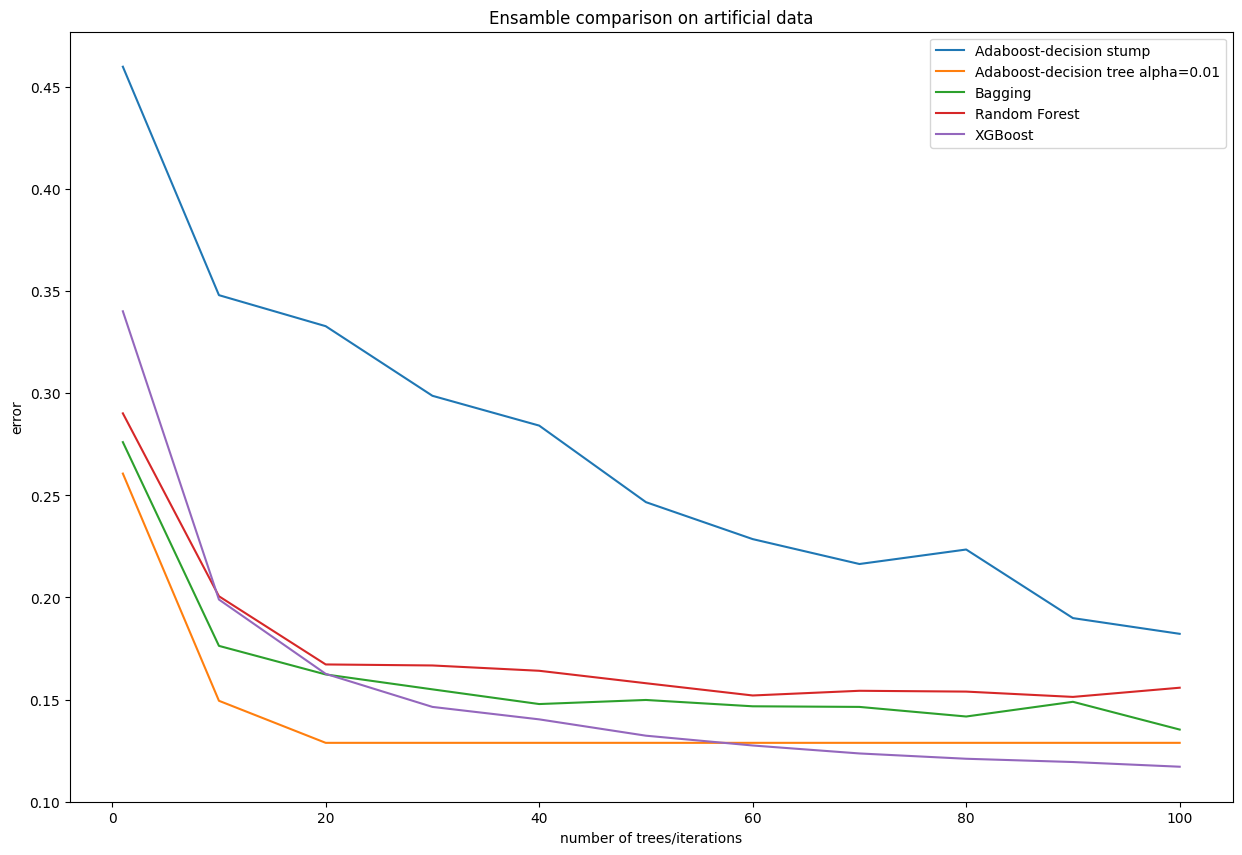

In [12]:
def test_on_articifial():
    X_train,y_train=generate_data(2000)
    X_test,y_test=generate_data(10000)
    title="Ensamble comparison on artificial data"
    plot_error_on_data_set(X_train,y_train,X_test,y_test,title)
test_on_articifial()

####  Phishing websites dataset: https://archive.ics.uci.edu/dataset/327/phishing+websites

elapsed time for Adaboost-decision stump method: 3.543768882751465
elapsed time for Adaboost-decision tree alpha=0.01 method: 4.688430309295654
elapsed time for Bagging method: 1.329653024673462
elapsed time for Random Forest method: 3.124774217605591
elapsed time for XGBoost method: 0.41409826278686523


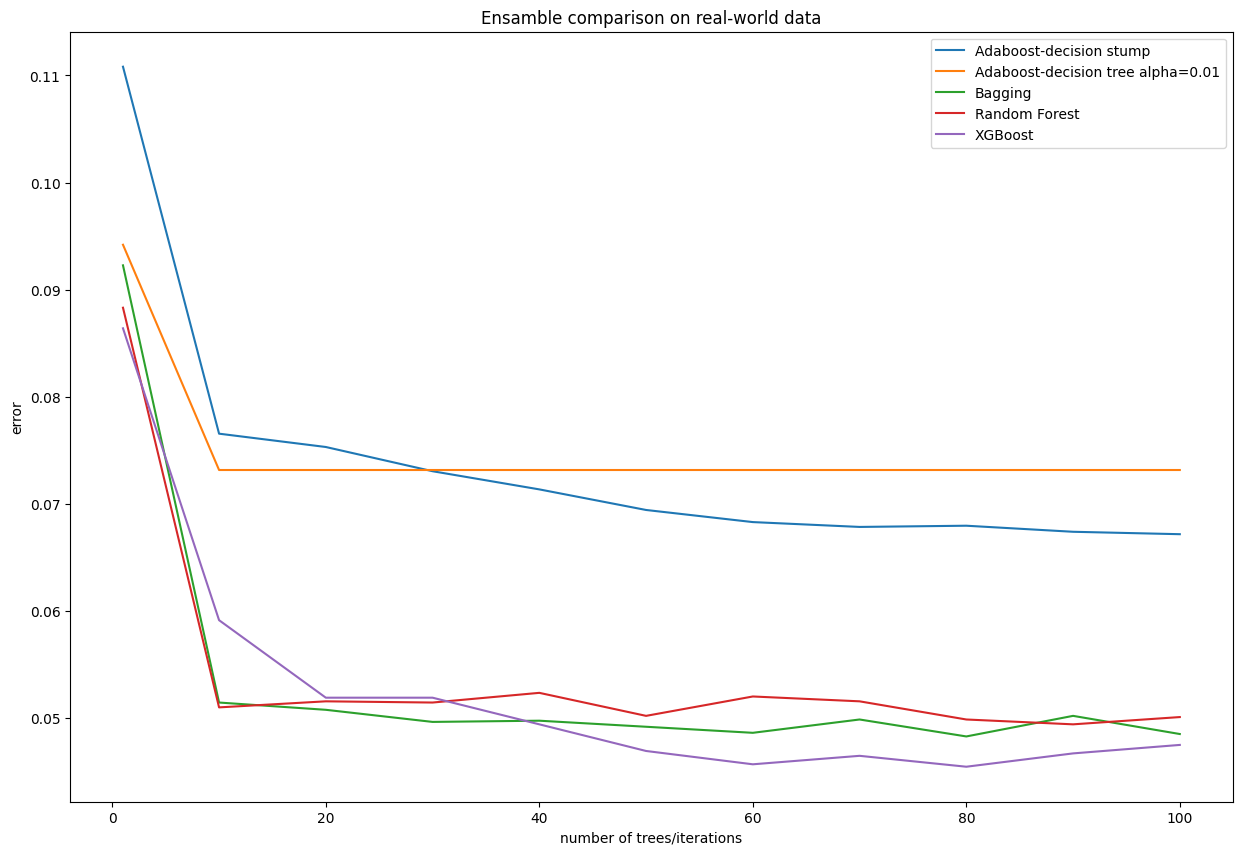

In [15]:
def test_on_real():
    file = arff.loadarff("Training Dataset.arff")
    df=pd.DataFrame(file[0]).apply(pd.to_numeric,axis=1)
    y=df["Result"].to_numpy()
    X=df.drop("Result",axis=1).to_numpy()
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.8)
    title="Ensamble comparison on real-world data"
    plot_error_on_data_set(X_train,y_train,X_test,y_test,title)
test_on_real()